# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
#old_store = paths.AnalysisStorage("mstis.nc")
old_store = paths.Storage("mstis.nc")  # if not actually doing analysis, but loading network, etc

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

One of the points of SRTIS is that we use a bias (which comes from an estimate of the crossing probability) in order to improve our sampling.

In [5]:
# this is how we would get it out of a simulation (although the actual simulation here has bad stats)
# first, we need the crossing probabilities, which we get when we calculate the rate
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
rates = network.rate_matrix(old_store.steps)

In [6]:
# next, we make those crossing probabilities into a bias function. 
# this version takes advantage of the fact that all the 
bias = sum([
    paths.BiasEnsembleTable.ratios_from_dictionary(
        {ens : t.tcp(lambda_ens)
         for (ens, lambda_ens) in zip(t.ensembles + network.special_ensembles['ms_outer'].keys(), [0.04, 0.09, 0.16, 0.25])}
    )
    for t in network.sampling_transitions
], paths.BiasEnsembleTable(pd.DataFrame(), {}))
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,6.70337,7.02408,NaN,NaN,NaN,NaN,NaN,NaN,12.2994
Out A 1,0.149179,1,1.04784,NaN,NaN,NaN,NaN,NaN,NaN,1.8348
Out A 2,0.142367,0.954342,1,NaN,NaN,NaN,NaN,NaN,NaN,1.75103
Out B 0,NaN,NaN,NaN,1,3.88526,5.18147,NaN,NaN,NaN,8.35162
Out B 1,NaN,NaN,NaN,0.257383,1,1.33362,NaN,NaN,NaN,2.14956
Out B 2,NaN,NaN,NaN,0.192995,0.749838,1,NaN,NaN,NaN,1.61182
Out C 0,NaN,NaN,NaN,NaN,NaN,NaN,1,2.80658,4.64561,6.19294
Out C 1,NaN,NaN,NaN,NaN,NaN,NaN,0.356305,1,1.65526,2.20658
Out C 2,NaN,NaN,NaN,NaN,NaN,NaN,0.215257,0.604136,1,1.33307
[UnionEnsemble],0.081305,0.545018,0.571093,0.119737,0.46521,0.620415,0.161474,0.45319,0.750146,1


In [7]:
# Here are results that I got from a 20k MC step run
dict_A = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.13293104100673198,
    "Out A 2" : 0.044370838092911397,
    "[UnionEnsemble]" : 0.021975696374764188
}

dict_B = {
    "Out B 0" : 1.0,
    "Out B 1" : 0.13846029208307947,
    "Out B 2" : 0.042622152070289694,
    "[UnionEnsemble]" : 0.021955804935886884    
}

dict_C = {
    "Out C 0" : 1.0,
    "Out C 1" : 0.19485705066078274,
    "Out C 2" : 0.053373003923696649,
    "[UnionEnsemble]" : 0.029175949467020165    
}

In [8]:
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']
enslist_A = network.transitions[(stateA, stateB)].ensembles + network.special_ensembles['ms_outer'].keys()
enslist_B = network.transitions[(stateB, stateA)].ensembles + network.special_ensembles['ms_outer'].keys()
enslist_C = network.transitions[(stateC, stateA)].ensembles + network.special_ensembles['ms_outer'].keys()
bias_A = paths.BiasEnsembleTable.ratios_from_dictionary({ens : dict_A[ens.name] for ens in enslist_A})
bias_B = paths.BiasEnsembleTable.ratios_from_dictionary({ens : dict_B[ens.name] for ens in enslist_B})
bias_C = paths.BiasEnsembleTable.ratios_from_dictionary({ens : dict_C[ens.name] for ens in enslist_C})

In [9]:
bias_A.df

,Out A 0,Out A 1,Out A 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,45.5048
Out A 1,0.132931,1,2.99591,6.049
Out A 2,0.0443708,0.333788,1,2.01909
[UnionEnsemble],0.0219757,0.165317,0.495273,1


In [10]:
bias_B.df

,Out B 0,Out B 1,Out B 2,[UnionEnsemble]
Out B 0,1,7.22229,23.462,45.546
Out B 1,0.13846,1,3.24855,6.30632
Out B 2,0.0426222,0.307829,1,1.94127
[UnionEnsemble],0.0219558,0.158571,0.515127,1


In [11]:
bias_C.df

,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out C 0,1,5.13197,18.7361,34.2748
Out C 1,0.194857,1,3.65085,6.67869
Out C 2,0.053373,0.273909,1,1.82935
[UnionEnsemble],0.0291759,0.14973,0.546642,1


In [12]:
bias = bias_A + bias_B + bias_C

In [13]:
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,NaN,NaN,NaN,NaN,NaN,NaN,45.5048
Out A 1,0.132931,1,2.99591,NaN,NaN,NaN,NaN,NaN,NaN,6.049
Out A 2,0.0443708,0.333788,1,NaN,NaN,NaN,NaN,NaN,NaN,2.01909
Out B 0,NaN,NaN,NaN,1,7.22229,23.462,NaN,NaN,NaN,45.546
Out B 1,NaN,NaN,NaN,0.13846,1,3.24855,NaN,NaN,NaN,6.30632
Out B 2,NaN,NaN,NaN,0.0426222,0.307829,1,NaN,NaN,NaN,1.94127
Out C 0,NaN,NaN,NaN,NaN,NaN,NaN,1,5.13197,18.7361,34.2748
Out C 1,NaN,NaN,NaN,NaN,NaN,NaN,0.194857,1,3.65085,6.67869
Out C 2,NaN,NaN,NaN,NaN,NaN,NaN,0.053373,0.273909,1,1.82935
[UnionEnsemble],0.0219757,0.165317,0.495273,0.0219558,0.158571,0.515127,0.0291759,0.14973,0.546642,1


In [14]:
ms_outer_id = bias.ensembles_to_ids[network.special_ensembles['ms_outer'].keys()[0]]
ms_outer_count = len(network.special_ensembles['ms_outer'].values()[0])
for col in bias.dataframe.columns:
    val_from_ms_outer = bias.dataframe.loc[ms_outer_id, col]
    bias.dataframe.set_value(index=ms_outer_id, col=col, value=val_from_ms_outer * ms_outer_count)
    val_to_ms_outer = bias.dataframe.loc[col, ms_outer_id]
    bias.dataframe.set_value(index=col, col=ms_outer_id, value=val_to_ms_outer / ms_outer_count)
bias.df

,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,Out C 0,Out C 1,Out C 2,[UnionEnsemble]
Out A 0,1,7.5227,22.5373,NaN,NaN,NaN,NaN,NaN,NaN,15.1683
Out A 1,0.132931,1,2.99591,NaN,NaN,NaN,NaN,NaN,NaN,2.01633
Out A 2,0.0443708,0.333788,1,NaN,NaN,NaN,NaN,NaN,NaN,0.673029
Out B 0,NaN,NaN,NaN,1,7.22229,23.462,NaN,NaN,NaN,15.182
Out B 1,NaN,NaN,NaN,0.13846,1,3.24855,NaN,NaN,NaN,2.10211
Out B 2,NaN,NaN,NaN,0.0426222,0.307829,1,NaN,NaN,NaN,0.64709
Out C 0,NaN,NaN,NaN,NaN,NaN,NaN,1,5.13197,18.7361,11.4249
Out C 1,NaN,NaN,NaN,NaN,NaN,NaN,0.194857,1,3.65085,2.22623
Out C 2,NaN,NaN,NaN,NaN,NaN,NaN,0.053373,0.273909,1,0.609783
[UnionEnsemble],0.0659271,0.49595,1.48582,0.0658674,0.475713,1.54538,0.0875278,0.44919,1.63993,1


Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [15]:
scheme = paths.SRTISScheme(network, bias=bias, engine=engine)

In [16]:
scheme.move_decision_tree()

In [17]:
for m in scheme.movers['repex']:
    print m.name, scheme.real_choice_probability[m]

EnsembleHop Out A 1->Out A 0 0.0020325203252
EnsembleHop Out A 0->Out A 1 0.0020325203252
EnsembleHop Out A 1->Out A 2 0.0020325203252
EnsembleHop Out A 2->Out A 1 0.0020325203252
EnsembleHop Out C 0->Out C 1 0.0020325203252
EnsembleHop Out C 1->Out C 0 0.0020325203252
EnsembleHop Out C 1->Out C 2 0.0020325203252
EnsembleHop Out C 2->Out C 1 0.0020325203252
EnsembleHop Out B 0->Out B 1 0.0020325203252
EnsembleHop Out B 1->Out B 0 0.0020325203252
EnsembleHop Out B 2->Out B 1 0.0020325203252
EnsembleHop Out B 1->Out B 2 0.0020325203252
EnsembleHop [UnionEnsemble]->Out A 2 0.0020325203252
EnsembleHop Out A 2->[UnionEnsemble] 0.0020325203252
EnsembleHop [UnionEnsemble]->Out C 2 0.0020325203252
EnsembleHop Out C 2->[UnionEnsemble] 0.0020325203252
EnsembleHop [UnionEnsemble]->Out B 2 0.0020325203252
EnsembleHop Out B 2->[UnionEnsemble] 0.0020325203252


Now we'll visualize the SRTIS move scheme.

In [18]:
movevis = paths.visualize.MoveTreeBuilder()
#movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
#SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [19]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [20]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [21]:
storage = paths.Storage("srtis.nc", "w", use_uuid=old_store.reference_by_uuid)
storage.save(template)

(store.snapshots[BaseSnapshot],
 3,
 UUID('c3b43935-58af-11e6-8ff6-00000000237f'))

In [22]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    move_scheme=scheme
)

In [23]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=1
    ))
print n_steps_to_run

1230


In [24]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [25]:
%%time
multiplier = 2
srtis.run_until(multiplier*n_steps_to_run)

Working on Monte Carlo cycle number 2460.
DONE! Completed 2460 Monte Carlo cycles.
CPU times: user 1min 16s, sys: 4.68 s, total: 1min 21s
Wall time: 1min 21s


In [26]:
#storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [27]:
%%time
#storage = paths.AnalysisStorage("srtis.nc")
#scheme = storage.schemes[0]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [28]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 1.271% (expected 0.41%) of the cycles with acceptance 0/3 (0.00%)
repex ran 42.797% (expected 3.66%) of the cycles with acceptance 28/101 (27.72%)
shooting ran 36.017% (expected 3.66%) of the cycles with acceptance 59/85 (69.41%)
minus ran 0.000% (expected 0.24%) of the cycles with acceptance 0/0 (nan%)
pathreversal ran 19.915% (expected 2.03%) of the cycles with acceptance 35/47 (74.47%)


In [29]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out A 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 1 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out A 1 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out A 2 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 1 ran 13.983% (expected 0.41%) of the cycles with acceptance 27/33 (81.82%)
OneWayShootingMover Out C 0 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out C 2 ran 0.000% (expected 0.41%) of the cycles with acceptance 0/0 (nan%)
OneWayShootingMover Out B 2 ran 22.034% (expected 0.41%) of the cycles with acceptance 32/52 (61.54%)


In [30]:
scheme.move_summary(storage.steps, 'minus')

SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)
SingleReplicaMinus ran 0.000% (expected 0.08%) of the cycles with acceptance 0/0 (nan%)


In [31]:
scheme.move_summary(storage.steps, 'repex')

EnsembleHop Out A 2->[UnionEnsemble] ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 0->Out C 1 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out B 1->Out B 0 ran 11.017% (expected 0.20%) of the cycles with acceptance 1/26 (3.85%)
EnsembleHop Out B 0->Out B 1 ran 0.424% (expected 0.20%) of the cycles with acceptance 1/1 (100.00%)
EnsembleHop Out C 1->Out C 0 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out A 0->Out A 1 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop [UnionEnsemble]->Out C 2 ran 0.424% (expected 0.20%) of the cycles with acceptance 0/1 (0.00%)
EnsembleHop Out C 1->Out C 2 ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out C 2->[UnionEnsemble] ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
EnsembleHop Out A 1->Out A 0 ran 0.000% (expected 0.20%) of the cycles with acceptance 

In [32]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 11.441% (expected 0.20%) of the cycles with acceptance 18/27 (66.67%)
PathReversal ran 0.847% (expected 0.20%) of the cycles with acceptance 2/2 (100.00%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 7.203% (expected 0.20%) of the cycles with acceptance 14/17 (82.35%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.424% (expected 0.20%) of the cycles with acceptance 1/1 (100.00%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)
PathReversal ran 0.000% (expected 0.20%) of the cycles with acceptance 0/0 (nan%)


In [33]:
replica = storage.samplesets[0].samples[0].replica
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage.steps)
print len(ensemble_trace)

2461


In [34]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out A 0
1 : Out A 1
2 : Out A 2
3 : Out C 0
4 : Out C 1
5 : Out C 2
6 : Out B 0
7 : Out B 1
8 : Out B 2
9 : [UnionEnsemble]


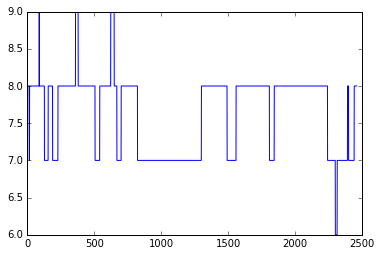

In [35]:
plt.plot([srtis_ensemble_numbers[e] for e in ensemble_trace])

In [36]:
count = 0
for i in range(len(ensemble_trace)-1):
    [this_val, next_val] = [srtis_ensemble_numbers[ensemble_trace[k]] for k in [i,i+1]]
    if this_val == 1 and next_val == 0:
        count += 1
count

0

In [37]:
hist_numbers = [srtis_ensemble_numbers[e] for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

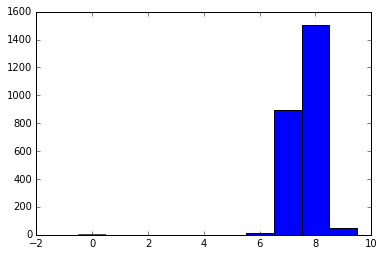

In [38]:
plt.hist(hist_numbers, bins=bins);

In [39]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = {i : srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))}
df = pd.DataFrame(columns=[colnames[i] for i in colnames])

In [40]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        normalized = hist.normalized()
        local_df = pd.DataFrame([normalized.values()], index=[i], columns=[colnames[k] for k in normalized.keys()])
        df = df.append(local_df)

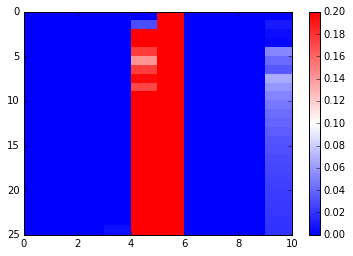

In [41]:
plt.pcolormesh(df.fillna(0.0), cmap="bwr", vmin=0.0, vmax=0.2);
plt.gca().invert_yaxis()
plt.colorbar()